# Finetuning stable-diffusion-2-inpainting with PEFT/LORA training

### 1. Prepare Images and respective masks (atleast 10-15 variations of same object images)
### 2. Finetune the SD-2 Inpaint model for the prepared images and masks using LORA
### 3. With LoRA, the fientuning process is too fast as only linear layers are trained on top of frozen model weights
### 4. Track the model training process using Weights and Biases (WandB)
### 5. Save the LoRA weights and load them for inference. Use CPU offloading and attention slicing to save GPU memory
### 6. Model Interpretability:- Important to explain customers that model is not black box, instead it undertsands what it is asked to generate
### 7. Explainable model generate heat maps around the object of interest mentioned in the prompt. 
### 8. Darker portions of heat map indicate the object is at desired location

### Installing required packages

In [1]:
# !pip install torch==2.0.1+cu118 torchvision==0.15.2 --index-url https://download.pytorch.org/whl/cu118
# !pip install xformers==0.0.20
# !pip install transformers accelerate sentencepiece wandb bitsandbytes
# !pip install git+https://github.com/huggingface/diffusers

In [2]:
import math
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed

from PIL import Image, ImageDraw
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.auto import tqdm

from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionInpaintPipeline, UNet2DConditionModel
from diffusers.loaders import AttnProcsLayers
from diffusers.models.attention_processor import LoRAAttnProcessor
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version
from diffusers.utils.import_utils import is_xformers_available

import bitsandbytes as bnb

logger = get_logger(__name__, log_level="INFO")

In [25]:
df = pd.read_csv("inpainting_dataset/arbonne-metadata.csv")

In [26]:
df.head()

,sl_no,image_name,mask_name,prompt
0,1,1.png,1_mask.jpg,a photo of body lotion
1,2,2.png,2_mask.jpg,a photo of two body lotions
2,3,3.png,3_mask.jpg,a photo of two body lotions
3,4,4.png,4_mask.jpg,a photo of two body lotions
4,5,5.png,5_mask.jpg,a photo of two body lotions


In [5]:
len(df["image_name"])

11

In [6]:
def prepare_mask_and_masked_image(image, mask):
    image = np.array(image)
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image).to(dtype=torch.float32) / 127.5 - 1.0

    mask = np.array(mask.convert("L"))
    mask = mask.astype(np.float32) / 255.0
    mask = mask[None, None]
    mask[mask < 0.5] = 0
    mask[mask >= 0.5] = 1
    mask = torch.from_numpy(mask)

    masked_image = image * (mask < 0.5)

    return mask, masked_image

In [7]:
mixed_precision = "fp16" # or "bf16"
report_to = "wandb"
output_dir = "arbonne-model"
batch_size = 1
max_train_steps = None
checkpointing_steps = 100
train_epochs = 50
gradient_accumulation_steps = 2
lr_warmup_steps = 0
learning_rate=4e-05
max_grad_norm = 1.0
global_step = 0
first_epoch = 0

In [8]:
accelerator = Accelerator(
    gradient_accumulation_steps=gradient_accumulation_steps,
    mixed_precision=mixed_precision,
    log_with=report_to
)
    
weight_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    weight_dtype = torch.float16

In [9]:
pretrained_model_name = "stabilityai/stable-diffusion-2-inpainting"

tokenizer = CLIPTokenizer.from_pretrained(pretrained_model_name, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(pretrained_model_name, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(pretrained_model_name, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(pretrained_model_name, subfolder="unet")

vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.requires_grad_(False)

unet.to(accelerator.device, dtype=weight_dtype)
vae.to(accelerator.device, dtype=weight_dtype)
text_encoder.to(accelerator.device, dtype=weight_dtype)

unet.enable_xformers_memory_efficient_attention()

In [10]:
class DreamBoothDataset(Dataset):
    """
    A dataset to prepare the instance and class images with the prompts for fine-tuning the model.
    It pre-processes the images and the tokenizes prompts.
    """

    def __init__(
        self,
        instance_images_path,
        masks_path,
        metadata,
        tokenizer,
        tokenizer_max_length,
        size=512,
    ):
        self.size = size
        self.tokenizer = tokenizer
        self.images = metadata["image_name"]
        self.masks = metadata["mask_name"]
        self.instance_prompt = metadata["prompt"]
        self.tokenizer_max_length = tokenizer_max_length
        self.instance_images_path = instance_images_path
        self.masks_path = masks_path
        self.num_instance_images = len(self.instance_images_path)

        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        example = {}
        instance_image = Image.open(self.instance_images_path + "/" + self.images[index])
        mask_image = Image.open(self.masks_path + "/" + self.masks[index]).convert("L")
        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")

        example["PIL_images"] = instance_image.resize((512, 512))
        example["mask_images"] = mask_image.resize((512, 512))
        example["instance_images"] = self.image_transforms(instance_image)

        example["instance_prompt_ids"] = self.tokenizer(
            self.instance_prompt[index],
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer_max_length,
        ).input_ids
        
        mask, masked_image = prepare_mask_and_masked_image(example["PIL_images"], example["mask_images"])
        
        example["masks"] = mask
        example["masked_images"] = masked_image

        return example

In [11]:
images_dir = "inpainting_dataset/images-no-text"
masks_dir = "inpainting_dataset/masks"

train_ds = DreamBoothDataset(instance_images_path=images_dir, masks_path=masks_dir, metadata=df, tokenizer=tokenizer, tokenizer_max_length=77)

In [12]:
train_ds[0]

{'PIL_images': <PIL.Image.Image image mode=RGB size=512x512>,
 'mask_images': <PIL.Image.Image image mode=L size=512x512>,
 'instance_images': tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 'instance_prompt_ids': [49406, 320, 1125, 539, 

In [13]:
train_ds[0]["instance_images"].shape, train_ds[0]["masks"].shape

(torch.Size([3, 512, 512]), torch.Size([1, 1, 512, 512]))

In [14]:
def collate_fn(examples):
    input_ids = [example["instance_prompt_ids"] for example in examples]
    pixel_values = [example["instance_images"] for example in examples]
    masks = [example["masks"] for example in examples]
    masked_images = [example["masked_images"] for example in examples]

    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    input_ids = tokenizer.pad({"input_ids": input_ids}, padding=True, return_tensors="pt").input_ids
    masks = torch.stack(masks)
    masked_images = torch.stack(masked_images)
    batch = {"input_ids": input_ids, "pixel_values": pixel_values, "masks": masks, "masked_images": masked_images}
    return batch

In [15]:
train_dataloader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        collate_fn=collate_fn
    )

In [16]:
for i, j in enumerate(train_dataloader):
    print(j["input_ids"].shape, j["pixel_values"].shape, j["masks"].shape, j["masked_images"].shape)

torch.Size([1, 7]) torch.Size([1, 3, 512, 512]) torch.Size([1, 1, 1, 512, 512]) torch.Size([1, 1, 3, 512, 512])
torch.Size([1, 7]) torch.Size([1, 3, 512, 512]) torch.Size([1, 1, 1, 512, 512]) torch.Size([1, 1, 3, 512, 512])
torch.Size([1, 9]) torch.Size([1, 3, 512, 512]) torch.Size([1, 1, 1, 512, 512]) torch.Size([1, 1, 3, 512, 512])
torch.Size([1, 9]) torch.Size([1, 3, 512, 512]) torch.Size([1, 1, 1, 512, 512]) torch.Size([1, 1, 3, 512, 512])
torch.Size([1, 9]) torch.Size([1, 3, 512, 512]) torch.Size([1, 1, 1, 512, 512]) torch.Size([1, 1, 3, 512, 512])
torch.Size([1, 7]) torch.Size([1, 3, 512, 512]) torch.Size([1, 1, 1, 512, 512]) torch.Size([1, 1, 3, 512, 512])
torch.Size([1, 9]) torch.Size([1, 3, 512, 512]) torch.Size([1, 1, 1, 512, 512]) torch.Size([1, 1, 3, 512, 512])
torch.Size([1, 7]) torch.Size([1, 3, 512, 512]) torch.Size([1, 1, 1, 512, 512]) torch.Size([1, 1, 3, 512, 512])
torch.Size([1, 9]) torch.Size([1, 3, 512, 512]) torch.Size([1, 1, 1, 512, 512]) torch.Size([1, 1, 3, 512

In [17]:
# Set correct lora layers

lora_attn_procs = {}
for name in unet.attn_processors.keys():
    cross_attention_dim = None if name.endswith("attn1.processor") else unet.config.cross_attention_dim
    if name.startswith("mid_block"):
        hidden_size = unet.config.block_out_channels[-1]
    elif name.startswith("up_blocks"):
        block_id = int(name[len("up_blocks.")])
        hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
    elif name.startswith("down_blocks"):
        block_id = int(name[len("down_blocks.")])
        hidden_size = unet.config.block_out_channels[block_id]

    lora_attn_procs[name] = LoRAAttnProcessor(hidden_size=hidden_size, cross_attention_dim=cross_attention_dim)

unet.set_attn_processor(lora_attn_procs)
lora_layers = AttnProcsLayers(unet.attn_processors)

In [18]:
optimizer_class = bnb.optim.AdamW8bit
learning_rate = (learning_rate * gradient_accumulation_steps * batch_size * accelerator.num_processes)

# Optimizer creation
params_to_optimize = lora_layers.parameters()
optimizer = optimizer_class(params_to_optimize, lr=learning_rate)

noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name, subfolder="scheduler")

In [19]:
# Scheduler and math around the number of training steps.
import math

overrode_max_train_steps = False
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
if max_train_steps is None:
    max_train_steps = train_epochs * num_update_steps_per_epoch
    overrode_max_train_steps = True

print(f"Max Train Steps : {max_train_steps}")

lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=lr_warmup_steps * gradient_accumulation_steps,
    num_training_steps=max_train_steps * gradient_accumulation_steps,
)

Max Train Steps : 300


In [20]:
# Prepare everything with our `accelerator`.
total_batch_size = batch_size * accelerator.num_processes * gradient_accumulation_steps

lora_layers, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    lora_layers, optimizer, train_dataloader, lr_scheduler
)

In [21]:
if accelerator.is_main_process:
    accelerator.init_trackers("arbonne-lora")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shreyassk. Use `wandb login --relogin` to force relogin


In [22]:
from tqdm import tqdm

# Only show the progress bar once on each machine.
progress_bar = tqdm(range(global_step, max_train_steps), disable=not accelerator.is_local_main_process)
progress_bar.set_description("Steps")

resolution = 512
for epoch in range(first_epoch, train_epochs):
    unet.train()
    train_loss = 0.0
    for step, batch in enumerate(train_dataloader):
        with accelerator.accumulate(unet):
            # Convert images to latent space
            latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample()
            latents = latents * vae.config.scaling_factor
            
            # Convert masked images to latent space
            masked_latents = vae.encode(batch["masked_images"].reshape(batch["pixel_values"].shape).to(dtype=weight_dtype)).latent_dist.sample()
            masked_latents = masked_latents * vae.config.scaling_factor
            
            pixel_values = batch["pixel_values"].to(dtype=weight_dtype)
            model_input = pixel_values
            
            masks = batch["masks"]
            # resize the mask to latents shape as we concatenate the mask to the latents
            mask = torch.stack([
                torch.nn.functional.interpolate(mask, size=(resolution // 8, resolution // 8))
                for mask in masks
            ])
            mask = mask.reshape(-1, 1, resolution // 8, resolution // 8)
            
            # Sample noise that we'll add to the latents
            noise = torch.randn_like(latents)
            bsz = latents.shape[0]
            
            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device
            )
            timesteps = timesteps.long()

            # Add noise to the model input according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
            
            # Concatentate the noised latents with the mask and masked latents
            latent_model_input = torch.cat([noisy_latents, mask, masked_latents], dim=1).to(dtype=weight_dtype)
            
            # Get the text embedding for conditioning
            encoder_hidden_states = text_encoder(batch["input_ids"])[0]
            
            # Predict the noise residual
            noise_pred = unet(latent_model_input, timesteps, encoder_hidden_states).sample
            
            # Get the target for loss depending on the prediction type
            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(model_input, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

            loss = F.mse_loss(noise_pred.float(), target.float(), reduction="mean")
            avg_loss = accelerator.gather(loss.repeat(batch_size)).mean()
            train_loss += avg_loss.item() / gradient_accumulation_steps
            
            accelerator.backward(loss)
            if accelerator.sync_gradients:
                params_to_clip = lora_layers.parameters()
                accelerator.clip_grad_norm_(params_to_clip, max_grad_norm)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        # Checks if the accelerator has performed an optimization step behind the scenes
        if accelerator.sync_gradients:
            progress_bar.update(1)
            global_step += 1
            accelerator.log({"train_loss": train_loss}, step=global_step)
            train_loss = 0.0
       
            if global_step % checkpointing_steps == 0:
                if accelerator.is_main_process:
                    save_path = os.path.join(output_dir, f"checkpoint-{global_step}")
                    accelerator.save_state(save_path)
                    logger.info(f"Saved state to {save_path}")

        logs = {"step_loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
        progress_bar.set_postfix(**logs)
        accelerator.log(logs, step=global_step)

        if global_step >= max_train_steps:
            break

# Save the lora layers
accelerator.wait_for_everyone()
if accelerator.is_main_process:
    unet = unet.to(torch.float32)
    unet_lora_layers = unet.save_attn_procs(output_dir)
    
accelerator.end_training()

Steps:   0%|          | 0/300 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/diffusers/models/attention_processor.py:1402: FutureWarning: `LoRAAttnProcessor` is deprecated and will be removed in version 0.26.0. Make sure use AttnProcessor instead by settingLoRA layers to `self.{to_q,to_k,to_v,to_out[0]}.lora_layer` respectively. This will be done automatically when using `LoraLoaderMixin.load_lora_weights`
  deprecate(
Steps: 100%|██████████| 300/300 [02:17<00:00,  2.48it/s, lr=4e-5, step_loss=0.0145]     

lr,██████████▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁
step_loss,▁▄▁▅▂█▃▁▄▁▁▂▁▁▂▁▁▁▁▁▃▁▂▅▂▁▁▁▂▁▆▁▁▁▁▁▂▄▁▁
train_loss,▂▅▁▃▂█▁▁▄▃▁▁▁▂▄▁▄▁▁▁▃▁▁▅▂▁▁▁▃▂▃▂▁▁▁▂▁▅▁▁
lr,4e-05
step_loss,0.01451
train_loss,0.00726


![Learning rate decay](wandb_lr.png)

![wandb_lr_decay](wandb.png)

# Inference Code for finetuned model

In [1]:
import torch
from PIL import Image, ImageFilter
from diffusers import StableDiffusionInpaintPipeline, DDIMScheduler, DPMSolverMultistepScheduler

device = "cuda"
pipe = StableDiffusionInpaintPipeline.from_pretrained("stabilityai/stable-diffusion-2-inpainting", torch_dtype=torch.float16).to(device)

pipe.unet.load_attn_procs("./arbonne-model")
pipe.enable_attention_slicing()
pipe.enable_xformers_memory_efficient_attention()

In [2]:
# Image and Mask
image = Image.open("inpainting_dataset/images/6.png").convert("RGB").resize((512, 512))
mask_image = Image.open("inpainting_dataset/masks/6_mask.jpg").convert("L").resize((512, 512))

mask_img = mask_image.filter(ImageFilter.GaussianBlur(15))

In [11]:
prompt = "a photo of two body lotions, white coloured, in focus, in foreground, extremely sharp, photorealism"
negative_prompt = "low quality, unrealistic, cartoon, low resolution, animation"

num_samples = 4
guidance_scale = 9.5
num_inference_steps = 50

images = pipe(prompt,
              image=image,
              mask_image=mask_image,
              height=512,
              width=512,
              negative_prompt=negative_prompt,
              num_images_per_prompt=num_samples,
              num_inference_steps=num_inference_steps,
              guidance_scale=guidance_scale,
              generator=torch.Generator().manual_seed(42)).images

  0%|          | 0/50 [00:00<?, ?it/s]

In [4]:
from diffusers.utils import load_image
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

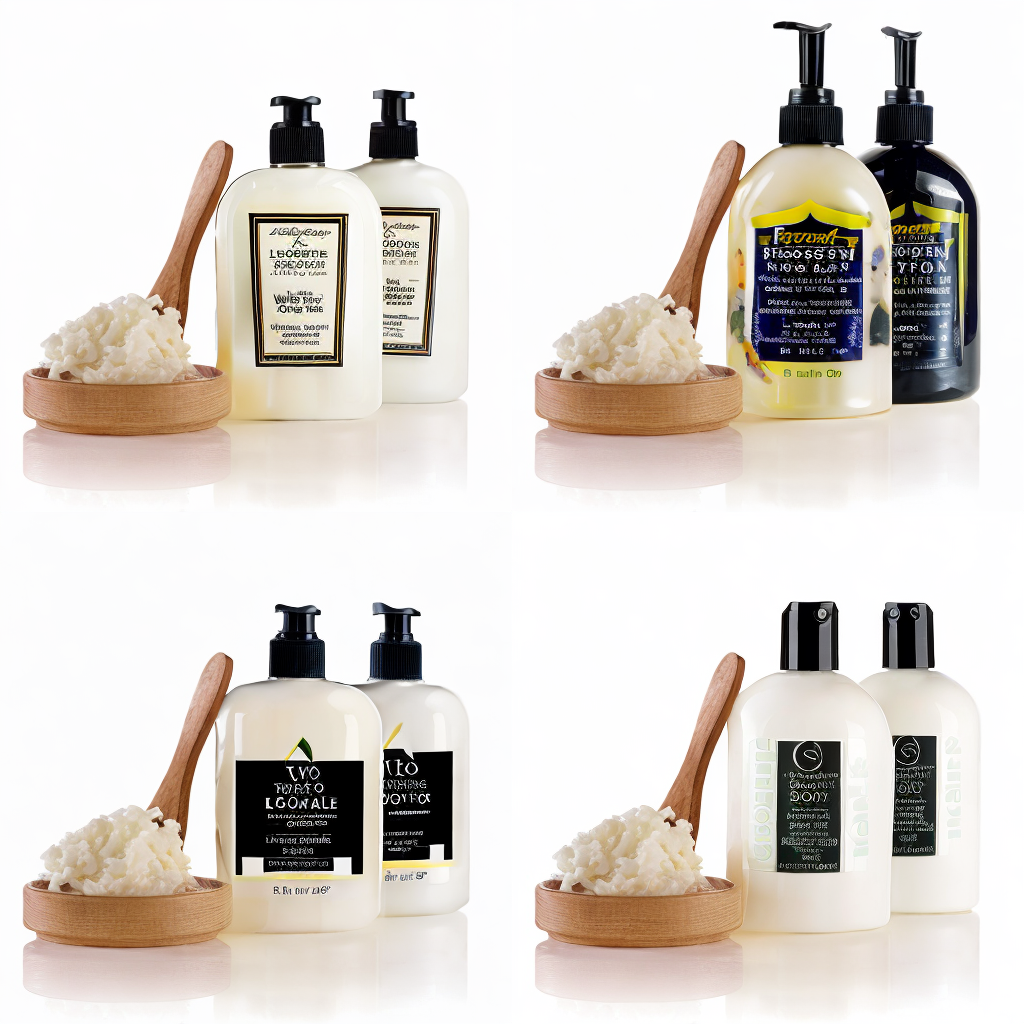

In [12]:
image_grid(images, 2, 2)

## Model Interpretability or Explainability using DAAM (Diffusion attentive Attribution Maps)

  0%|          | 0/50 [00:00<?, ?it/s]

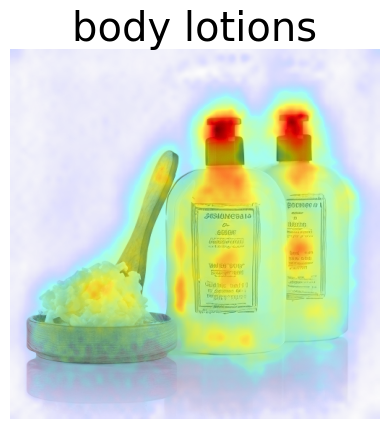

In [13]:
from daam import trace
import matplotlib.pyplot as plt

with torch.cuda.amp.autocast(dtype=torch.float16), torch.no_grad():
    with trace(pipe) as tc:
        out = pipe(prompt, image=image, mask_image=mask_image, num_inference_steps=num_inference_steps,
                   guidance_scale=guidance_scale, generator=torch.Generator().manual_seed(42))
        heat_map = tc.compute_global_heat_map()
        heat_map = heat_map.compute_word_heat_map('body lotions')
        heat_map.plot_overlay(out.images[0])
        plt.axis("off")
        plt.show()